# LAZY CELL UNROLLING
### by Matthew Jones

Here I present a lazy method for unrolling the jelly roll of a battery from a CT .tif slice.
This simple algorithm unwraps a binary representation of a phase (a.k.a. segmentation) in a battery from euclidean coords into radial and angular coords. This is a lazy version of the method presented by Matt Kok and takes considerable inspiration,
see the paper [here](https://pubs.rsc.org/en/content/articlehtml/2019/se/c9se00500e#imgfig1).

This method assumes:
1. The data is grayscale slice of the cyclindrical cell
2. That slices are oriented along the height of the cylindrical cell
3. That the casing is in the field-of-view and well resolved with good contrast from the rest of image (this is important because the casing is used to define the centre of the cell)

In this notebook I will go through step by step each stage in the workflow for unrolling a binary segmented image of a battery phase. Then at the end of the workflow I will make a python funtion that executes this workflow. This notebook is organised like so:
1. Exploration of sample data
2. Segmentation of casing
3. Example of how one might segment the phase of interest in a battery
4. Making utility masks 
    - interior/exterior mask
    - distance transform mask
    - angular position mask 
5. Applying unrolling to our example phase of interest
6. Plotting the results
7. Creating a python function that executes this above workflow
8. Conclusion

### 0. Import Libraries

In [1]:
# IMPORT LIBRARIES
import imageio as io
import numpy as np
import numpy.ma as ma
import skimage
from skimage.morphology import remove_small_objects as rem_smalls
from skimage.morphology import dilation, erosion
from scipy.ndimage import center_of_mass as c_of_m
from scipy.ndimage import distance_transform_edt as dist_trans
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import math

### 1. Exploration of sample data
Basic steps to see what the data looks like and what the phases of interest are.

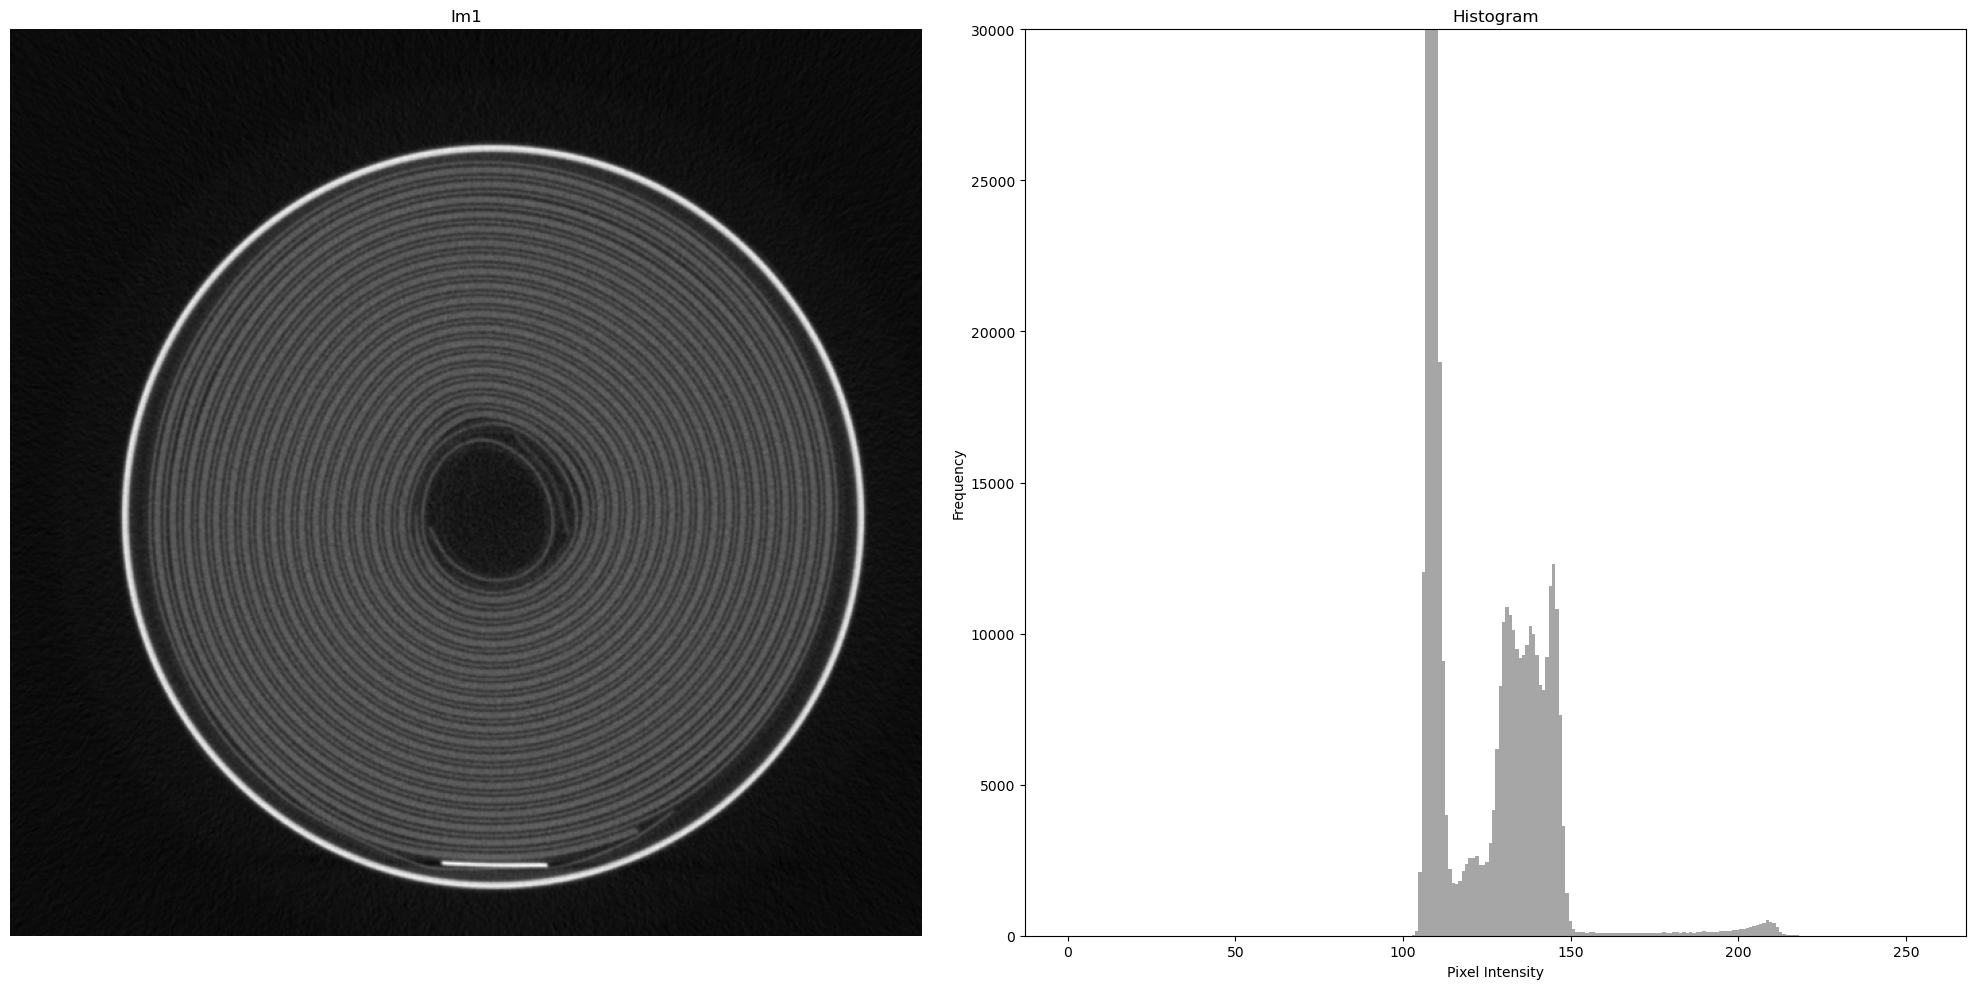

In [2]:
#READ IN THE DATA
ims_path = r'D:/Jude/images' #This is the path to our data
ims_paths_list = []
for l in os.listdir(ims_path): #creating a list containing paths to each slice
    ims_paths_list.append(os.path.join(ims_path,l))
    #these steps are only usefull if you wanted to apply unrolling to multple slices, slice-by-slice. 
im1 = io.v2.imread(ims_paths_list[0]) #read an image in list. This image will be unrolled in this example notebook.
im1 = skimage.img_as_ubyte(im1) #convert to 8bit

#BASIC IMAGE EXPLORATION
# Let's create a figure of a slice and its histogram
# Create a figure with two subplots: one for the image and one for the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Plot the image
ax1.imshow(im1, cmap='gray')
ax1.set_title('Im1')
ax1.axis('off')
# Flatten the image to a 1D array for the histogram
pixels = im1.flatten()
# Plot the histogram
ax2.hist(pixels, bins=256, range=(0, 255), color='gray', alpha=0.7)
ax2.set_ylim(0,30000)
ax2.set_title('Histogram')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('Frequency')
# Display the plot
plt.tight_layout()
plt.show()

From the grayscale CT slice above and histogram above we can now start to think about how to segment different parts of the image. The large low intensity peak is the background. The peaks in the middle are the active materials (electrodes, seperator etc.). The small peak at high intensity (at about 210 in the histo) is the casing.   

### 2. Segmentation of the casing
Lets now try find a decent threshold for the casing. This is a really important step because the casing segmentation is used to find the centre of mass of the cell. The C of M is very important for later unrolling steps.

Looking at the histogram above i'd guess; im1 > 180 is a reasonable approximation for a threshold.

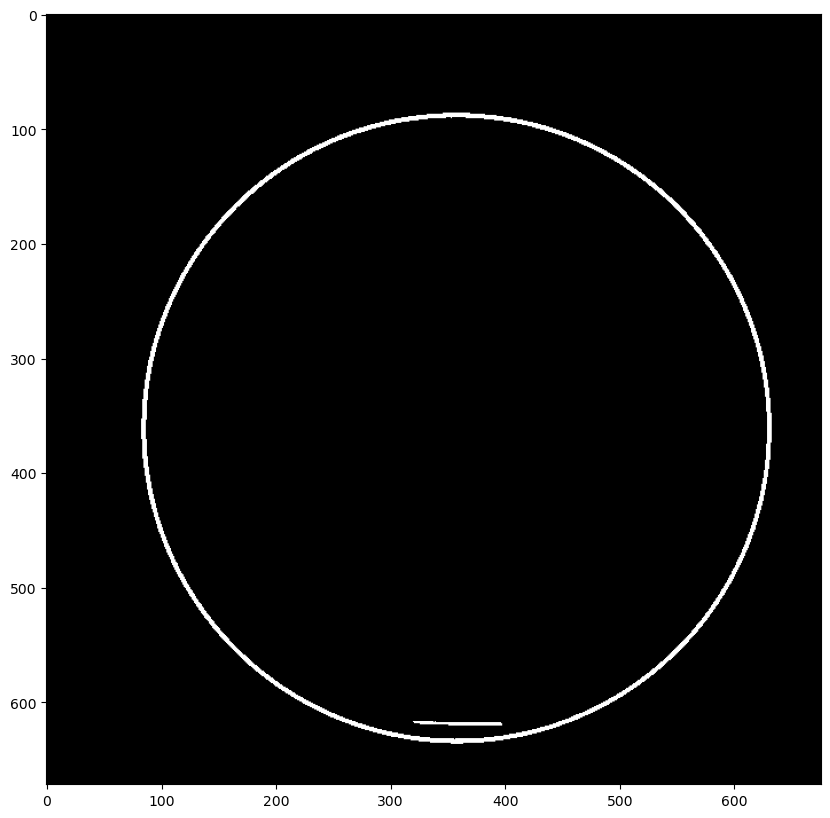

In [3]:
# plot this segmentation
im2 = (im1 > 180)
plt.figure(figsize=(10, 10))
plt.imshow(im2.astype(np.uint8), cmap='gray')
plt.show()
# lets also save im1, im2 so we can look at them in imagej or whatever preferred software
io.imwrite('D:/Jude/im1.tif', im1, format = 'tif')
io.imwrite('D:/Jude/im2.tif', im2.astype(np.uint8), format = 'tif')

Looking at that image it is a nice segmentation however the tab is erroneously included. This should be removed. This tab is a much smaller region than the casing so it can be removed by a remove small objects algorithm. The area of the tab is less than 100 x 10 px (a.k.a 1000px).

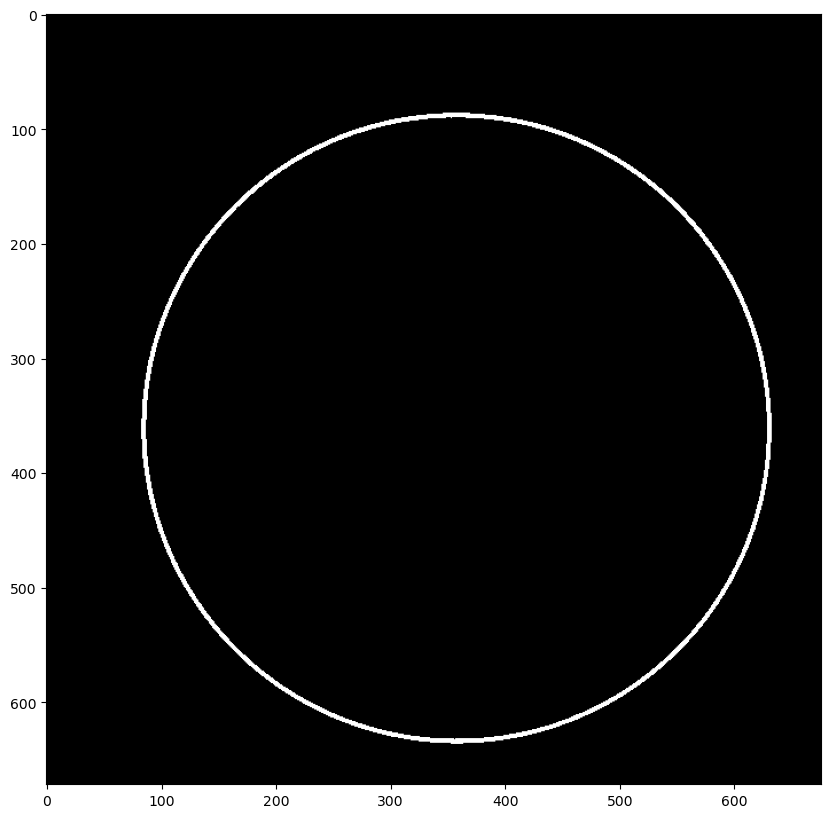

In [4]:
tab_area_is_smaller_than = 1000
casing_seg = rem_smalls(im2, min_size = tab_area_is_smaller_than)
plt.figure(figsize=(10, 10))
plt.imshow(casing_seg, cmap='gray')
plt.show()
io.imwrite('D:/Jude/casing.tif', casing_seg.astype(np.uint8), format = 'tif')

This succesfully removes the tab leaving a nice segmentation of the casing.

### 3. Example of a phase of interest segmentation 
Now we will create a sementation of a phase of interest in the battery. Please note this is quite a crude segmentation, please explore other segmentation methods! I am just doing this quickly as an example for this unrolling!

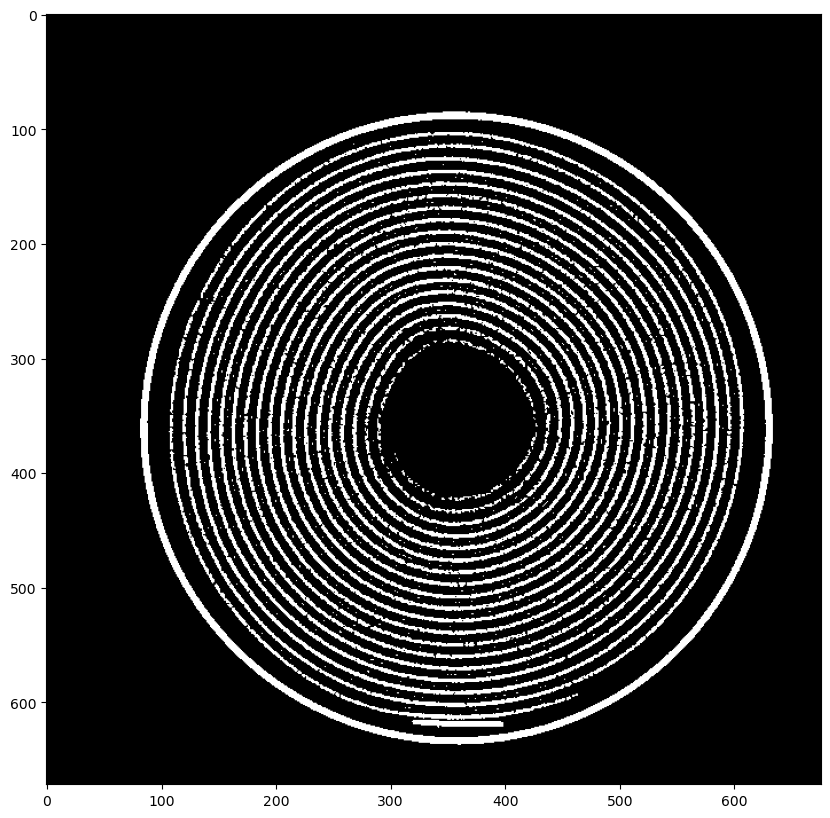

In [5]:
elec_seg = im1 > 142
plt.figure(figsize=(10, 10))
plt.imshow(elec_seg.astype(np.uint8), cmap='gray')
plt.show()

Obviously this isnt an acceptable segmentation of the electrode. We need to remove casing, tab and binary noise. The casing will be removed by dilating the casing segmentation and applying it as a mask to the image.

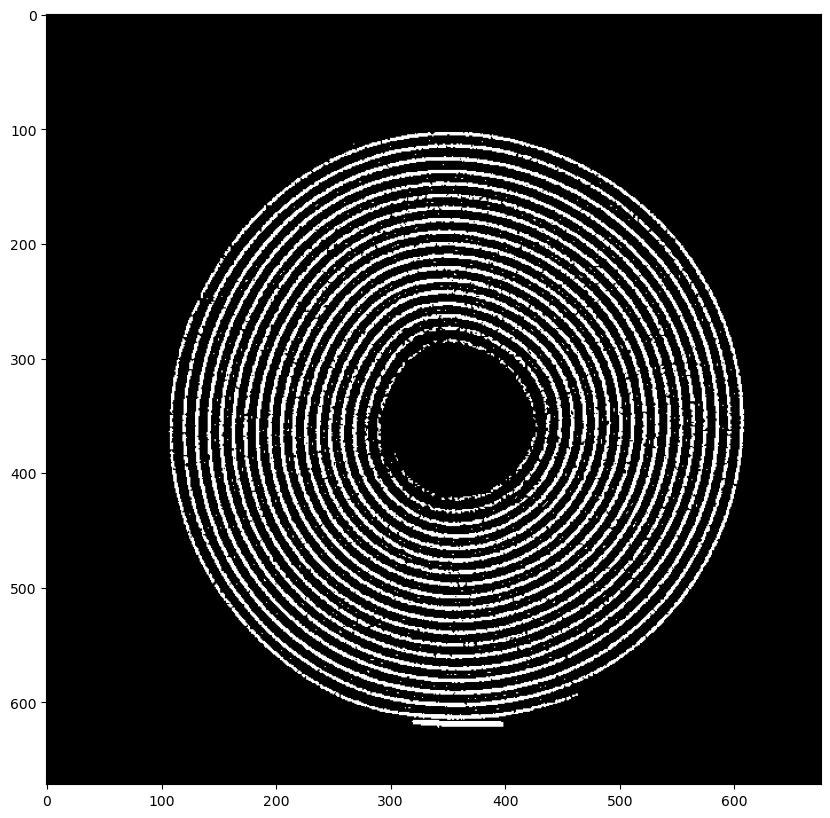

In [6]:
# segmentation above still has casing included
# remove using dilated casing mask
selem1 = skimage.morphology.square(7) #structering element to dilate casing mask
elec_seg = elec_seg * (1-dilation(casing_seg, selem1))
plt.figure(figsize=(10, 10))
plt.imshow(elec_seg.astype(np.uint8), cmap='gray')
plt.show()

The segmentation above still has binary noise, we remove this with binary opening closing operations.

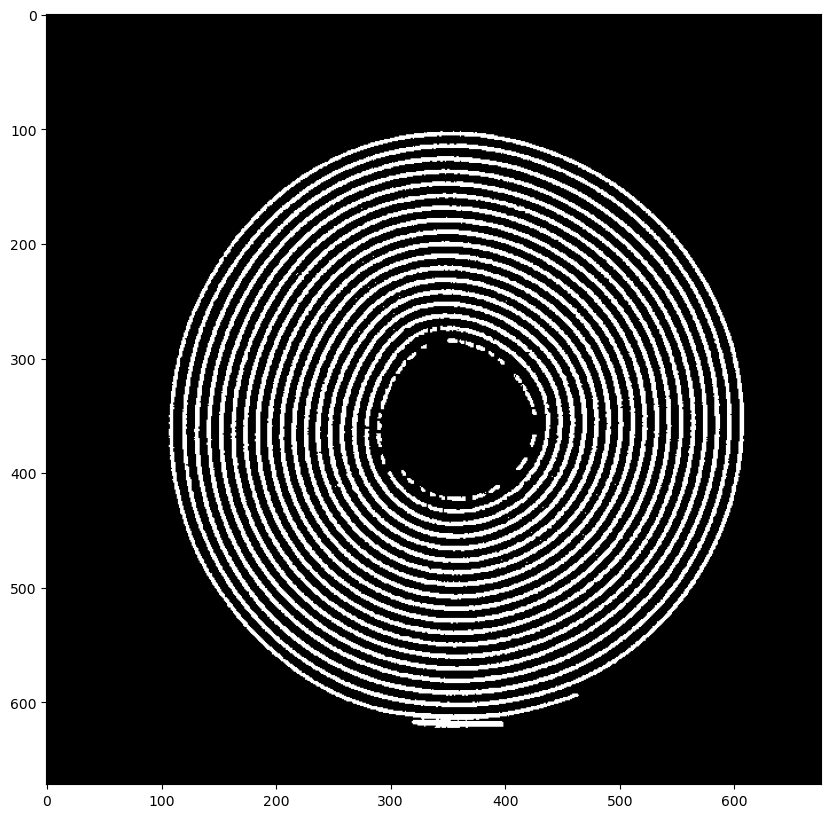

In [7]:
# segmentation above still has binary noise
# remove this with binary opening closing
selem2 = skimage.morphology.square(2) #structering element to binary erode
selem3 = skimage.morphology.square(5) #structering element to binary erode
elec_seg = dilation(erosion(elec_seg, selem2), selem3)
elec_seg = np.where(im1*elec_seg > 139, 1, 0)
plt.figure(figsize=(10, 10))
plt.imshow(elec_seg.astype(np.uint8), cmap='gray')
plt.show()
io.imwrite('D:/Jude/elec_seg.tif', elec_seg.astype(np.uint8), format = 'tif')

Looking much better. But still got that tab. Remove this now.

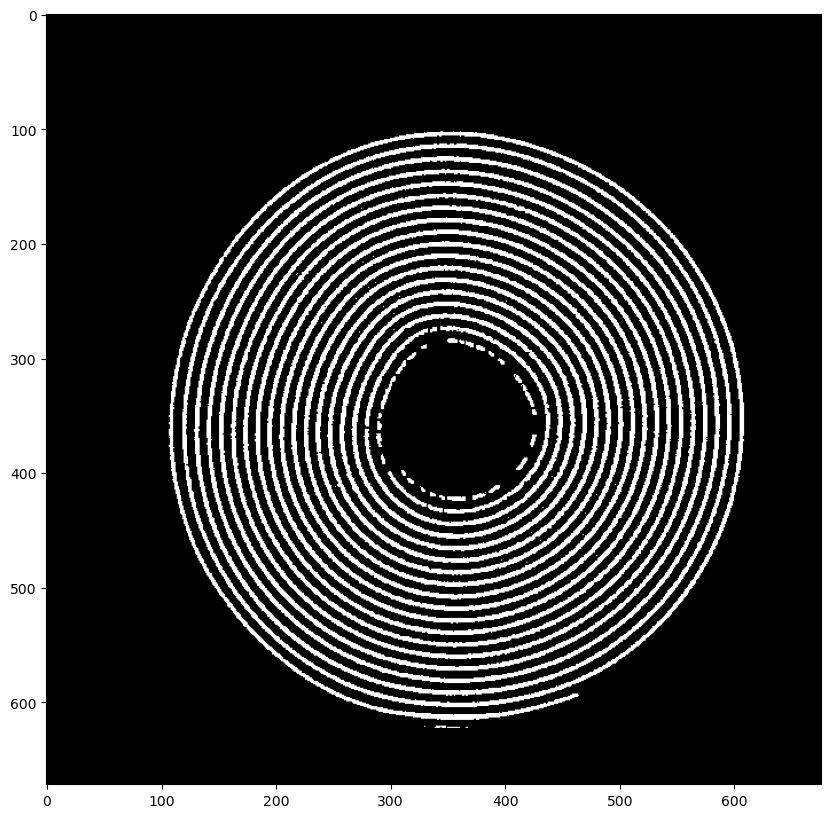

In [8]:
# Finally remove the tab frpm the segmentation
selem4 = skimage.morphology.square(4)
tab_seg = dilation(im2*(1-casing_seg),selem4)
elec_seg = elec_seg * (1-tab_seg)
plt.figure(figsize=(10, 10))
plt.imshow(elec_seg.astype(np.uint8), cmap='gray')
plt.show()
io.imwrite('D:/Jude/elec_seg.tif', elec_seg.astype(np.uint8), format = 'tif')

Decent, but not perfect! Some of the electrode in the center is missed by the segmentation. Also part of the tab is erroneously included. This is fine for this example though :)

Also I am going to get just the edges of this segmentation because it may make for a cleaner plot later...

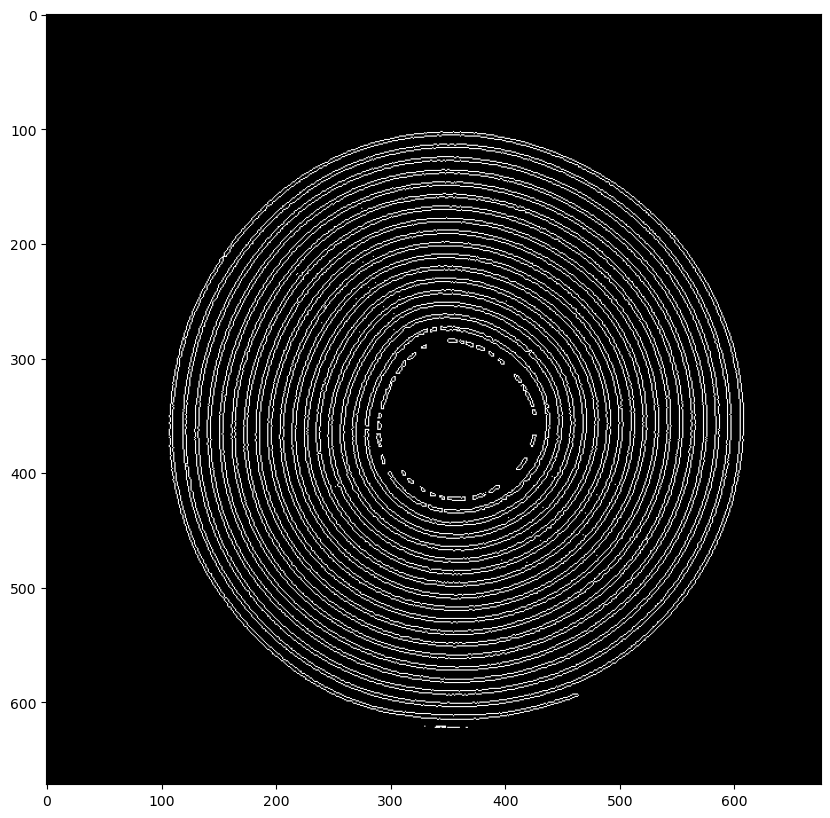

In [9]:
elec_seg_edge = elec_seg - erosion(elec_seg)
plt.figure(figsize=(10, 10))
plt.imshow(elec_seg_edge.astype(np.uint8), cmap='gray')
plt.show()
io.imwrite('D:/Jude/elec_seg_edge.tif', elec_seg_edge.astype(np.uint8), format = 'tif')

### 4. Making utility mask for the unrolling
Now we get into the meat of the unrolling workflow.

First find the centre of mass of the cell. As mentioned above this is critical to the unrolling. In order to find the CoM we used the scipy.ndimage.center_of_mass function, documentation found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html).

In [10]:
com = c_of_m(casing_seg)
com = tuple(int(x) for x in com) #converting to int to remove subpixels
print('C_of_M is '+ str(com))

C_of_M is (358, 356)


Next we create a simple utility mask where the inside of the battery is =1 and outside is = 0. This can be usefull for visualisation. This is not a particularly important step though...

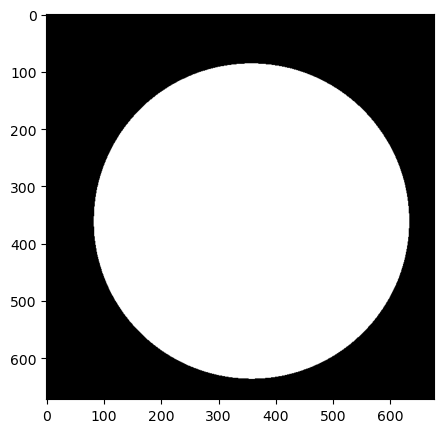

In [11]:
# first a basic utility mask where the inside of the battery is =1 and outside is = 0
flooded_cell = skimage.segmentation.flood_fill(casing_seg, com, new_value = 1)
plt.figure(figsize=(5, 5))
plt.imshow(flooded_cell.astype(np.uint8), cmap='gray')
plt.show()
io.imwrite('D:/Jude/flooded_cell.tif', flooded_cell.astype(np.uint8), format = 'tif')

Next we create an image where every pixel is given a value based on its radial distance from the C_of_M using a euclidean distance transform. This is important for the unrolling as it is used to define the y-coordinate in the unrolled coordinate system.

Here we used the scipy.ndimage.distance_transform_edt function, documentation found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html).

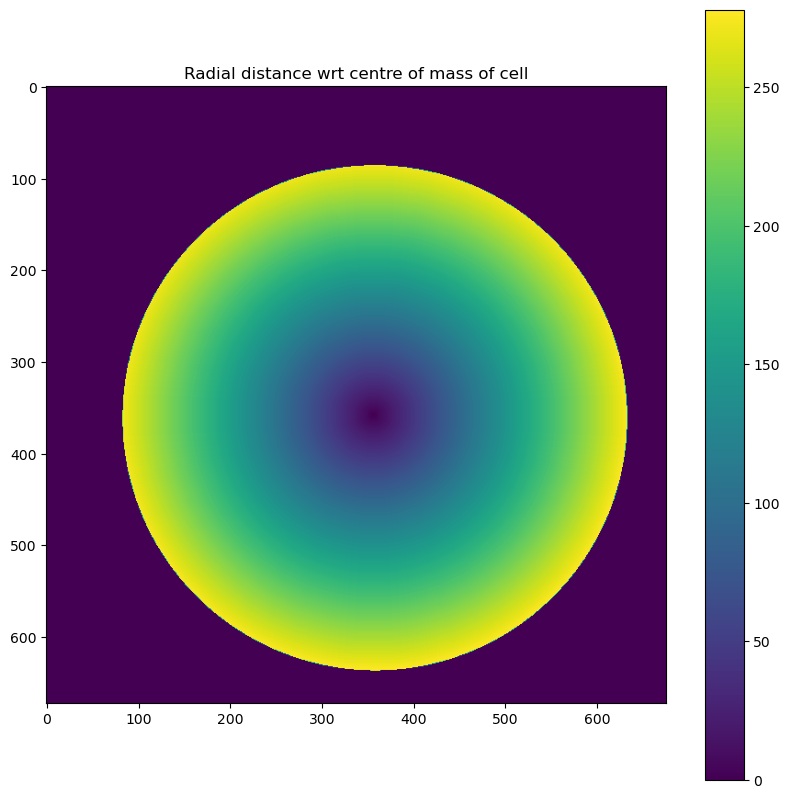

In [12]:
dist_transform = np.ones_like(im1)
dist_transform[com[0], com[1]] = 0
dist_transform = dist_trans(dist_transform.astype(np.uint16))
plt.figure(figsize=(10, 10))
plt.imshow((dist_transform*flooded_cell).astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Radial distance wrt centre of mass of cell')
plt.show()
io.imwrite('D:/Jude/dist_transform.tif', dist_transform.astype(np.uint16), format = 'tif')

So in the image above each pixel inside the cell casing is labelled with its radial distance (in pixels) from the centre of the cell as defined by the C_of_M of the casing.

Next we have to label each pixel inside the cell with its angular position with respect to the C_of_M. In order to do this we need to calculate:

$$
    \theta = arctan(\frac{x - x_0}{y - y_0})
$$

Where $\theta$ is the new angular position, $x$ is x-coord of a pixel, $x_0$ is the x-coord of the CoM, $y$ is y-coord of a pixel, and $y_0$ is the y-coord of the CoM. In order to handle this calculation as arrays in a element-wise fashion we used the numpy.arctan2 function, documentation found [here](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html).

In [13]:
arr = np.zeros_like(im1)
arr = np.indices(arr.shape)
print(arr[0]) #arr[0] here returns the y-coord of each point in the image 
print(arr[1]) #similarly arr[1] will return x-coord

[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [669 669 669 ... 669 669 669]
 [670 670 670 ... 670 670 670]
 [671 671 671 ... 671 671 671]]
[[  0   1   2 ... 673 674 675]
 [  0   1   2 ... 673 674 675]
 [  0   1   2 ... 673 674 675]
 ...
 [  0   1   2 ... 673 674 675]
 [  0   1   2 ... 673 674 675]
 [  0   1   2 ... 673 674 675]]


In [14]:
y_in = (arr[0] - com[0])
x_in = (arr[1] - com[1])
angular_arr = np.arctan2(x_in,y_in)
#print(angular_arr)

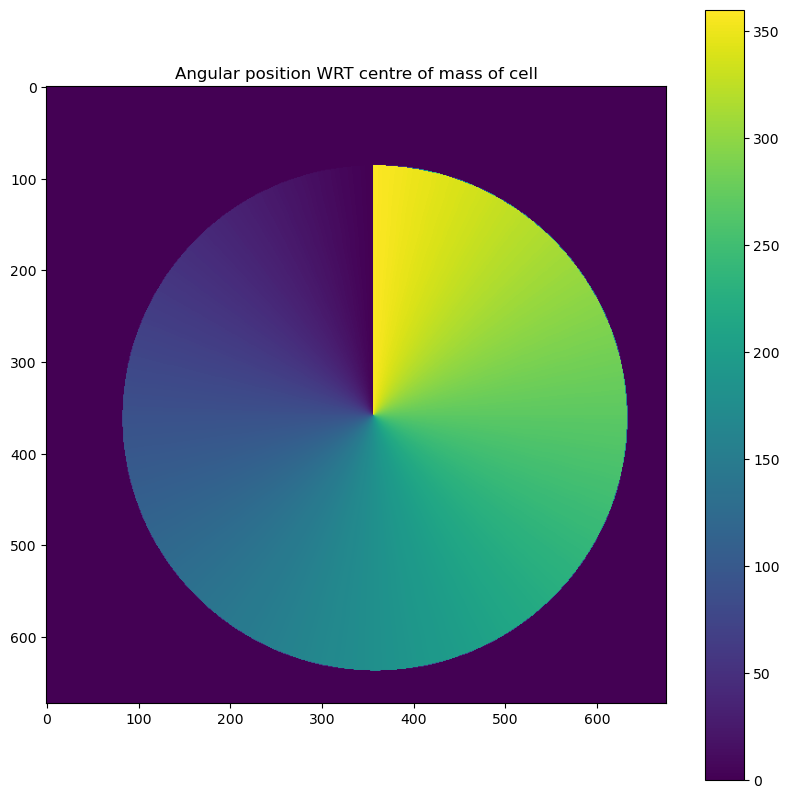

In [15]:
angular_arr = angular_arr * (180/math.pi) + 180 #convert into degrees with range between 0 - 360
plt.figure(figsize=(10, 10))
plt.imshow((angular_arr*flooded_cell).astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Angular position WRT centre of mass of cell')
plt.show()
io.imwrite('D:/Jude/angular_arr.tif', (angular_arr*flooded_cell).astype(np.uint16), format = 'tif')

So in the image above each pixel inside the cell casing is labelled with its angular position (in degrees) wrt the centre of the cell as defined by the C_of_M of the casing.

### 5. Apply unrolling
Now we mask out the radial/angular position images above with the segmentation of the phase of interest. This is shown below.

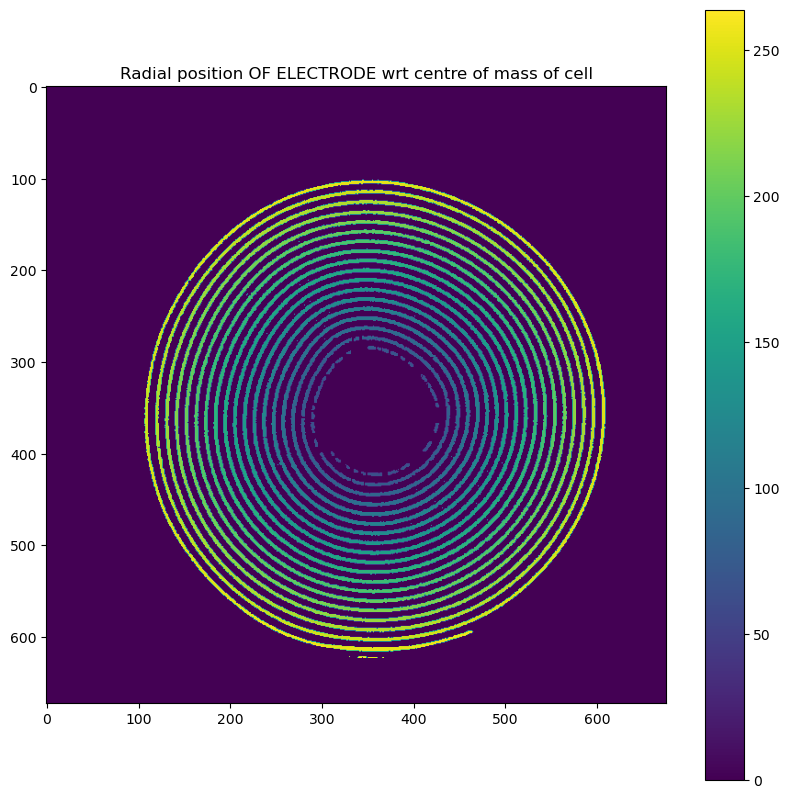

In [16]:
# radial
elec_radius_arr = dist_transform * elec_seg
elec_radius_arr_masked = ma.masked_where(elec_radius_arr == 0, elec_radius_arr)
plt.figure(figsize=(10, 10))
plt.imshow(elec_radius_arr.astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Radial position OF ELECTRODE wrt centre of mass of cell')
plt.show()

So in the image above each electrode pixel from our segmentation is labelled with its radial position.

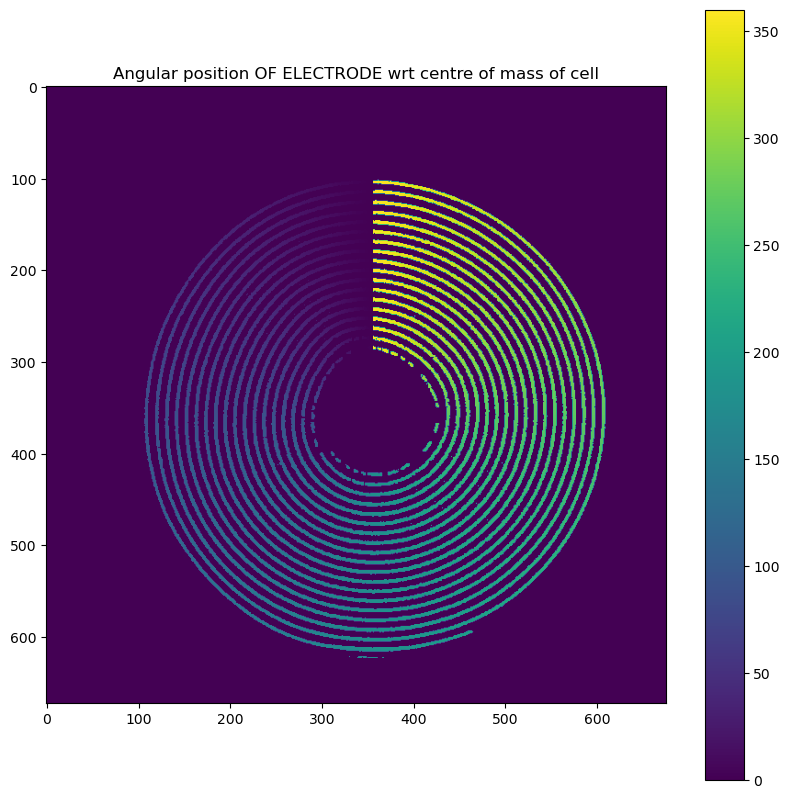

In [17]:
# anglular
elec_angle_arr = angular_arr * elec_seg
elec_angle_arr_masked = ma.masked_where(elec_angle_arr == 0, elec_angle_arr)
plt.figure(figsize=(10, 10))
plt.imshow(elec_angle_arr.astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Angular position OF ELECTRODE wrt centre of mass of cell')
plt.show()

So in the image above each electrode pixel is labelled with it angular postition.

We now reduce these radial/angular position of electrode images (above) to one dimensional arrays. By combing the two 1D arrays we can descirbe the position of the electrode phase in a coordinate system of radial distance and angle. The data is now unrolled!

In [18]:
#to 1D
elec_radius_arr_masked = elec_radius_arr_masked[elec_radius_arr_masked.mask == False].ravel()
elec_angle_arr_masked = elec_angle_arr_masked[elec_angle_arr_masked.mask == False].ravel()

### 6. Plotting unrolling results
Okay time time to plot results! We are going to 'lazy unroll' by plotting the electrode on a 2d scatter in terms of angular position and distance from centre.

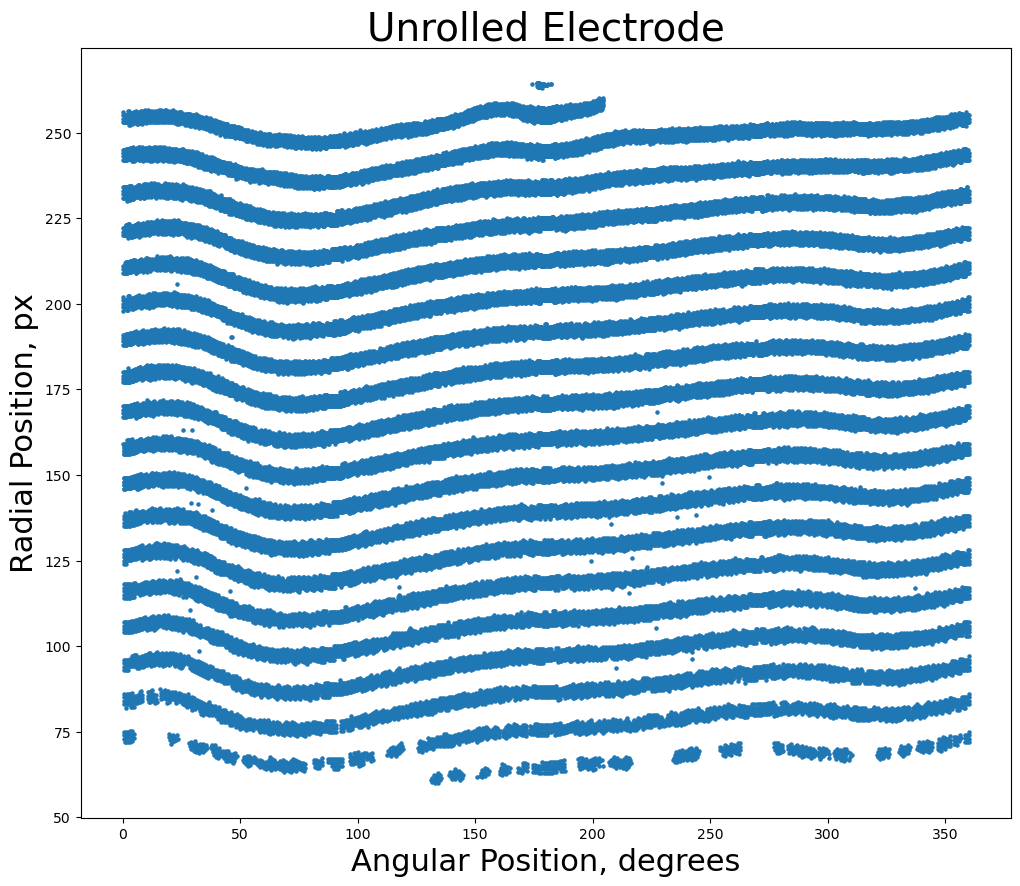

In [19]:
# now lets plot these like in the Matt Kok paper (fig.1)
plt.figure(figsize=(12, 10))
plt.scatter(elec_angle_arr_masked, elec_radius_arr_masked, s=5)

# Set the axis labels
plt.xlabel('Angular Position, degrees', fontsize = 22)
plt.ylabel('Radial Position, px', fontsize = 22)

# Set the plot title
plt.title('Unrolled Electrode', fontsize = 28)

# Display the plot
plt.show()

That looks like a good result. We can also include other phases that may be of interest. I am going to plot the casing. This should appear as a straight line across the top of the graph. In future work it would be intersting to plot different active phases in the cell to see thier interaction before/after multiple cycles. 

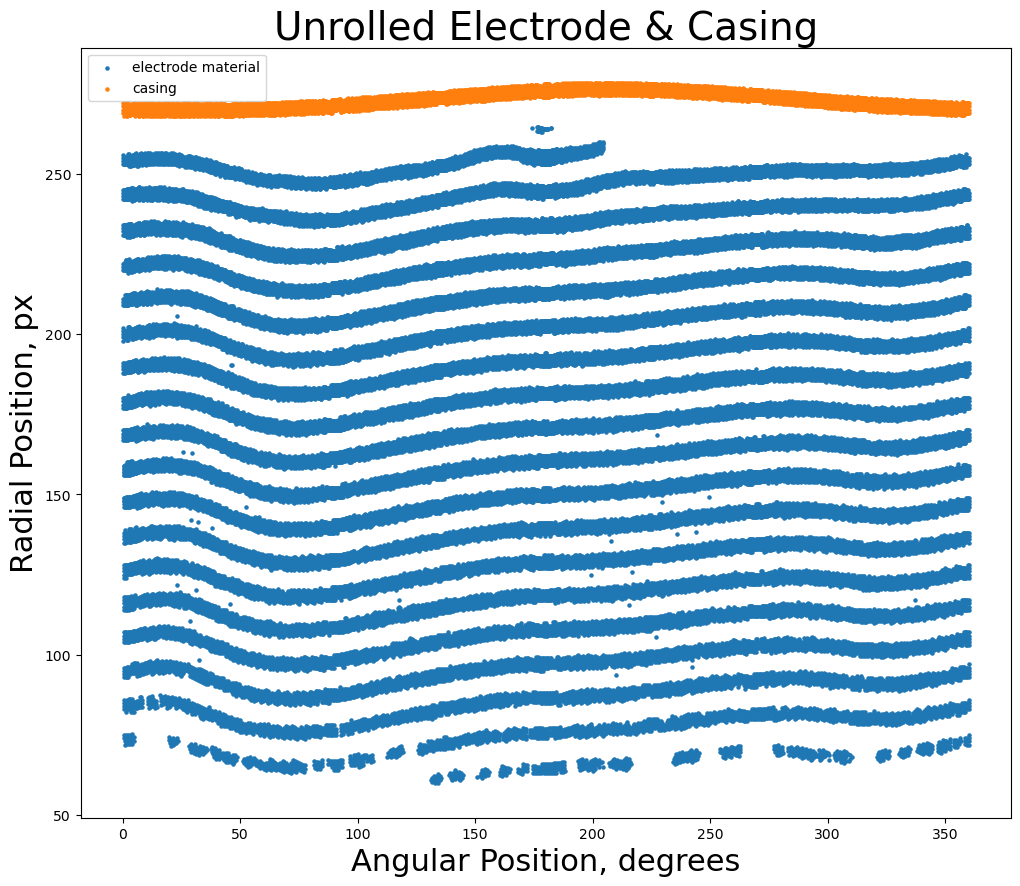

In [20]:
casing_radius_arr = dist_transform * casing_seg #casing seg mask radial pos
casing_radius_arr_masked = ma.masked_where(casing_radius_arr == 0, casing_radius_arr)
casing_radius_arr_masked = casing_radius_arr_masked[casing_radius_arr_masked.mask == False].ravel() #to 1d

casing_angle_arr = angular_arr * casing_seg #casing seg mask angular pos
casing_angle_arr_masked = ma.masked_where(casing_angle_arr == 0, casing_angle_arr)
casing_angle_arr_masked = casing_angle_arr_masked[casing_angle_arr_masked.mask == False].ravel() #to 1d

plt.figure(figsize=(12, 10))
plt.scatter(elec_angle_arr_masked, elec_radius_arr_masked, s=5, label = 'electrode material')
plt.scatter(casing_angle_arr_masked, casing_radius_arr_masked, s=5, label = 'casing')

# Set the axis labels
plt.xlabel('Angular Position, degrees', fontsize = 22)
plt.ylabel('Radial Position, px', fontsize = 22)

# Set the plot title
plt.title('Unrolled Electrode & Casing', fontsize = 28)
plt.legend()

# Display the plot
plt.show()

It may be more readable in future work to just use the edges of the segmentation in the plot, like so...

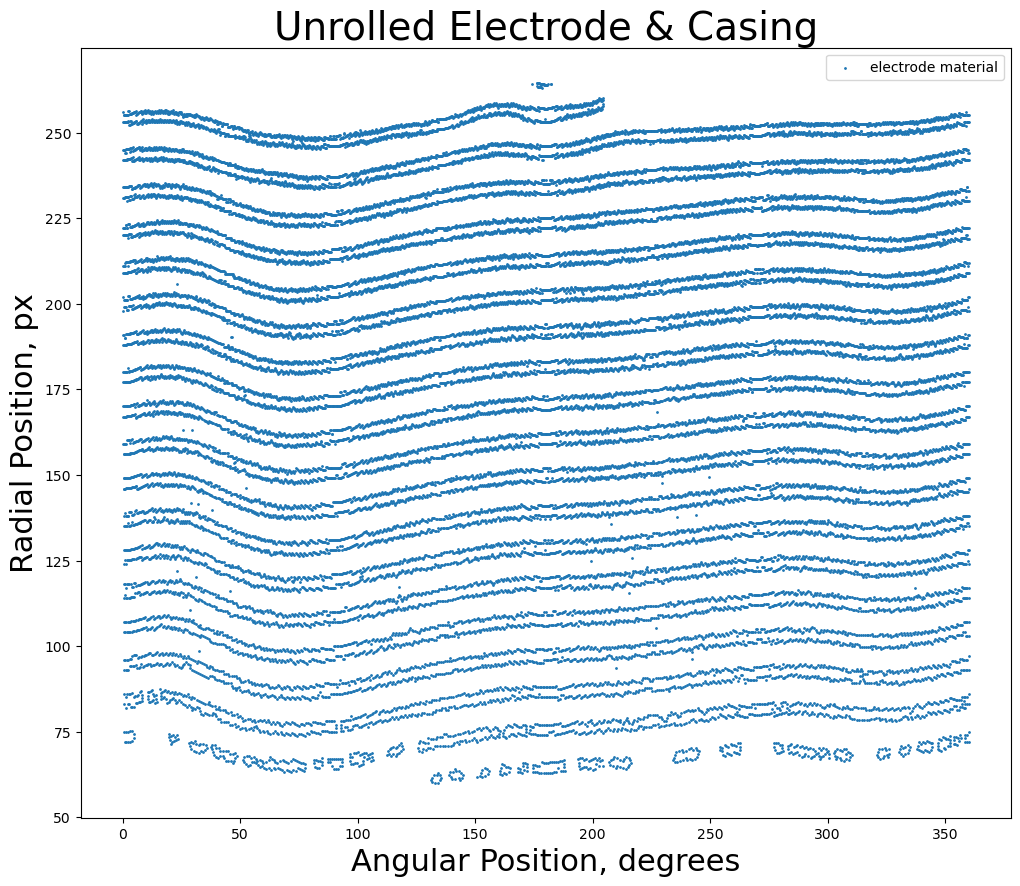

In [21]:
edges_radius_arr = dist_transform * elec_seg_edge #casing seg mask radial pos
edges_radius_arr_masked = ma.masked_where(edges_radius_arr == 0, edges_radius_arr)
edges_radius_arr_masked = edges_radius_arr_masked[edges_radius_arr_masked.mask == False].ravel() #to 1d

edges_angle_arr = angular_arr * elec_seg_edge #casing seg mask radial pos
edges_angle_arr_masked = ma.masked_where(edges_angle_arr == 0, edges_angle_arr)
edges_angle_arr_masked = edges_angle_arr_masked[edges_angle_arr_masked.mask == False].ravel() #to 1d

plt.figure(figsize=(12, 10))
plt.scatter(edges_angle_arr_masked, edges_radius_arr_masked, s=1, label = 'electrode material')

# Set the axis labels
plt.xlabel('Angular Position, degrees', fontsize = 22)
plt.ylabel('Radial Position, px', fontsize = 22)

# Set the plot title
plt.title('Unrolled Electrode & Casing', fontsize = 28)
plt.legend()

# Display the plot
plt.show()

OR another intersting way to plot these would be as 2d arrays, i.e. images. This may be more useful for work where you want to be able to compare differences in electrode position, after cycling for example, perhaps by subtracting before/after unrolled images...

Below i will turn these 1D arrays back into 2d arrays but in the new coordinate system...

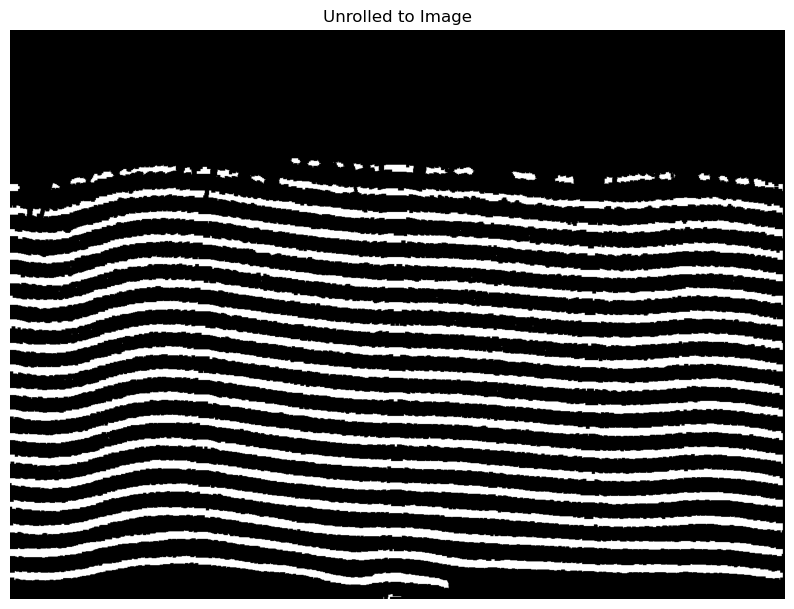

In [22]:
def unrolled_to_image(radius_arr, angle_arr, upsampling = 4, selem = 6, plotting = True):
    unrolled_2d_arr = np.zeros(((int(np.amax(radius_arr)+1))*upsampling, (int(np.amax(angle_arr)+1)*upsampling)))
    radius = tuple(int(x*upsampling) for x in radius_arr)
    angle = tuple(int(x*upsampling) for x in angle_arr)
    unrolled_2d_arr[radius, angle] = 1
    unrolled_2d_arr = erosion(dilation(unrolled_2d_arr, skimage.morphology.square(selem)), skimage.morphology.square(selem))
    if plotting == True:
        plt.figure(figsize=(10, 10))
        plt.title('Unrolled to Image')
        plt.axis('off')
        plt.imshow(unrolled_2d_arr, cmap='gray')
        plt.show()
    return unrolled_2d_arr

unrolled_image = unrolled_to_image(elec_radius_arr.ravel(), elec_angle_arr.ravel())

### 7. Create a function to execute workflow
We should make this whole workflow above executable by a function.

Function inputs:

1. grayscale image slice (2d array like, 8-bit)
2. corresponding segmentation (2d array like)
3. casing threshold value (of 8-bit image)(optional, arb. 180)
4. Tab area is smaller than (optional, assumes 1000)
5. Plotting = True/False (optional, assumes true)

Function outputs:

1. 1D-array of angular position
2. 1D-array of radial position
3. (Optional) plotting

In [23]:
def lazy_unroll(gray_im, seg_im, casing_thresh = 180, tab_area_is_smaller_than = 1000, plotting = True, to_image = False):
    casing = (gray_im > casing_thresh)
    casing = rem_smalls(casing, min_size = tab_area_is_smaller_than)
    com = c_of_m(casing)
    com = tuple(int(x) for x in com)
    dist_transform = np.ones_like(gray_im)
    dist_transform[com[0], com[1]] = 0
    dist_transform = dist_trans(dist_transform.astype(np.uint16))
    arr = np.zeros_like(gray_im)
    arr = np.indices(arr.shape)
    y_in = (arr[0] - com[0])
    x_in = (arr[1] - com[1])
    angular_arr = np.arctan2(x_in,y_in)
    angular_arr = angular_arr * (180/math.pi) + 180
    radius_arr = (dist_transform * seg_im).ravel()
    angle_arr = (angular_arr * seg_im).ravel()
    if plotting == True:
        plt.figure(figsize=(20, 20))
        plt.scatter(angle_arr, radius_arr, s=5)
        plt.xlabel('Angular Position, degrees', fontsize = 22)
        plt.ylabel('Radial Position, px', fontsize = 22)
        plt.title('Unrolled', fontsize = 28)
        plt.show()
    return angle_arr, radius_arr

### 8. Conclusion
This method is a simple way to unroll a segmented phase in a cylindrical cell. The result presented here are not perfect, mostly because the segmentation was done quickly. There are lots of other methods for unrolling spiral data sets, this is a very simple method. For more details see [Matt Kock's Paper](https://pubs.rsc.org/en/content/articlehtml/2019/se/c9se00500e#imgfig1)

If you have any questions please contact me :)

m.p.jones@ucl.ac.uk

Thanks